# Fantasy Football Draft Analysis

Author: Melody Bass

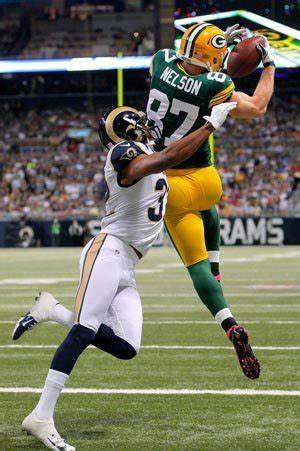

## Overview

## Business Problem

## Data Understanding

In [39]:
# Basics
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV
from fbprophet import Prophet as proph

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [40]:
# load in player fantasy stats data as player_df
player_df = pd.read_csv('data/league_data/player_data/Yahoo-406.l.12345-Players.csv')
player_df.head()

,ID,OR,Last Name,First Name,Team,Status,Status Details,Eligible Positions,Avg. Pick,Avg. Round,...,Ret TD (DT),XPR (DT),Pts Allow 0 (DT),Pts Allow 1-6 (DT),Pts Allow 7-13 (DT),Pts Allow 14-20 (DT),Pts Allow 21-27 (DT),Pts Allow 28-34 (DT),Pts Allow 35+ (DT),Image
0,406.p.30977,1,Allen,Josh,Buf,Available,NaN,QB,29.7,3.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/JqjwXUxHWb2L...
1,406.p.32676,2,Herbert,Justin,LAC,Available,NaN,QB,61.1,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/j0W7BC4RRiJB...
2,406.p.5228,3,Brady,Tom,TB,Available,NaN,QB,63.5,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/Z71ic_5aqQfG...
3,406.p.30123,4,Mahomes,Patrick,KC,Available,NaN,QB,16.6,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/oMIJokh4hdPk...
4,406.p.30182,5,Kupp,Cooper,LAR,Available,NaN,WR,42.0,4.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/hYxm3SR9yMjD...


In [41]:
# load in player fantasy points time series
wr_ts = pd.read_csv('data/wr_ts.csv')
wr_ts['Date'] = pd.to_datetime(wr_ts['Unnamed: 0'])
wr_ts = wr_ts.set_index('Date').drop('Unnamed: 0', axis=1)

qb_ts = pd.read_csv('data/qb_ts.csv')
qb_ts['Date'] = pd.to_datetime(qb_ts['Unnamed: 0'])
qb_ts = qb_ts.set_index('Date').drop('Unnamed: 0', axis=1)

rb_ts = pd.read_csv('data/rb_ts.csv')
rb_ts['Date'] = pd.to_datetime(rb_ts['Unnamed: 0'])
rb_ts = rb_ts.set_index('Date').drop('Unnamed: 0', axis=1)

te_ts = pd.read_csv('data/te_ts.csv')
te_ts['Date'] = pd.to_datetime(te_ts['Unnamed: 0'])
te_ts = te_ts.set_index('Date').drop('Unnamed: 0', axis=1)
qb_ts.tail(20)

,Aaron Rodgers,Baker Mayfield,Dak Prescott,Derek Carr,Deshaun Watson,Jalen Hurts,Jameis Winston,Joe Burrow,Josh Allen,Justin Fields,...,Mac Jones,Matt Ryan,Matthew Stafford,Patrick Mahomes II,Russell Wilson,Ryan Tannehill,Tom Brady,Trevor Lawrence,Trey Lance,Tua Tagovailoa
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-17,18.3,21.0,NaN,2.1,23.4,37.8,NaN,NaN,37.7,NaN,...,NaN,27.8,15.3,25.9,13.0,37.0,23.4,NaN,NaN,19.7
2020-12-24,26.1,8.0,NaN,23.2,26.8,20.6,NaN,NaN,32.3,NaN,...,NaN,19.9,0.7,20.2,19.9,18.3,29.9,NaN,NaN,8.9
2021-01-03,26.0,16.2,NaN,22.9,26.8,17.3,-0.1,NaN,20.3,NaN,...,NaN,22.7,23.6,NaN,18.1,28.4,31.3,NaN,NaN,18.2
2021-09-09,3.3,13.6,28.4,25.0,0.0,28.8,29.6,18.6,17.2,6.7,...,15.2,7.4,24.3,33.3,27.1,15.2,29.2,22.1,4.4,17.2
2021-09-16,26.8,18.5,8.5,24.2,0.0,21.8,10.3,13.3,17.7,4.5,...,7.4,19.3,18.2,25.0,23.3,14.6,29.6,8.8,0.0,0.5
2021-09-23,19.0,16.9,20.1,22.2,0.0,22.5,13.5,18.6,37.2,3.9,...,14.6,15.6,29.5,24.9,16.6,23.5,28.7,9.5,6.1,0.0
2021-09-30,24.1,9.3,27.0,15.4,0.0,28.2,13.0,22.3,21.0,8.3,...,17.9,29.0,20.3,32.3,22.6,18.8,11.1,17.8,20.4,0.0
2021-10-07,20.8,23.0,21.7,8.2,0.0,23.9,26.8,20.3,36.5,8.8,...,12.5,21.6,17.5,21.0,10.1,14.0,37.7,22.7,15.6,0.0
2021-10-14,23.7,13.2,27.8,21.5,0.0,26.0,0.0,23.8,29.7,14.3,...,15.8,0.0,26.2,25.0,0.0,13.9,19.0,15.9,0.0,22.4


In [42]:
# load in player fantasy stats data as player_df
qb_snap_ts = pd.read_csv('data/qb_snap_ts.csv')

qb_snap_ts['Date'] = qb_snap_ts['Unnamed: 0']
qb_snap_ts = qb_snap_ts.set_index('Date').drop('Unnamed: 0', axis=1)
qb_snap_ts = qb_snap_ts.reset_index()
qb_snap_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      85 non-null     object 
 1   snaps_Aaron Rodgers       85 non-null     float64
 2   snaps_Baker Mayfield      68 non-null     float64
 3   snaps_Dak Prescott        85 non-null     float64
 4   snaps_Derek Carr          85 non-null     float64
 5   snaps_Deshaun Watson      68 non-null     float64
 6   snaps_Jalen Hurts         34 non-null     float64
 7   snaps_Jameis Winston      85 non-null     float64
 8   snaps_Joe Burrow          34 non-null     float64
 9   snaps_Josh Allen          68 non-null     float64
 10  snaps_Justin Fields       17 non-null     float64
 11  snaps_Justin Herbert      34 non-null     float64
 12  snaps_Kirk Cousins        85 non-null     float64
 13  snaps_Kyler Murray        51 non-null     float64
 14  snaps_Lamar 

In [43]:
qb_snap_ts

,Date,snaps_Aaron Rodgers,snaps_Baker Mayfield,snaps_Dak Prescott,snaps_Derek Carr,snaps_Deshaun Watson,snaps_Jalen Hurts,snaps_Jameis Winston,snaps_Joe Burrow,snaps_Josh Allen,...,snaps_Mac Jones,snaps_Matt Ryan,snaps_Matthew Stafford,snaps_Patrick Mahomes II,snaps_Russell Wilson,snaps_Ryan Tannehill,snaps_Tom Brady,snaps_Trevor Lawrence,snaps_Trey Lance,snaps_Tua Tagovailoa
0,9/7/2017,82.0,NaN,74.0,66.0,48.0,NaN,0.0,NaN,NaN,...,NaN,59.0,71.0,0.0,49.0,NaN,81.0,NaN,NaN,NaN
1,9/14/2017,76.0,NaN,71.0,57.0,66.0,NaN,65.0,NaN,NaN,...,NaN,58.0,62.0,0.0,82.0,NaN,76.0,NaN,NaN,NaN
2,9/21/2017,70.0,NaN,47.0,51.0,71.0,NaN,53.0,NaN,NaN,...,NaN,68.0,70.0,0.0,73.0,NaN,64.0,NaN,NaN,NaN
3,9/28/2017,52.0,NaN,71.0,34.0,78.0,NaN,64.0,NaN,NaN,...,NaN,76.0,70.0,0.0,68.0,NaN,70.0,NaN,NaN,NaN
4,10/5/2017,60.0,NaN,74.0,0.0,64.0,NaN,72.0,NaN,NaN,...,NaN,0.0,61.0,0.0,68.0,NaN,74.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,12/2/2021,0.0,0.0,70.0,59.0,NaN,0.0,0.0,76.0,58.0,...,51.0,71.0,63.0,57.0,70.0,0.0,70.0,58.0,0.0,69.0
81,12/9/2021,63.0,63.0,85.0,63.0,NaN,0.0,0.0,67.0,78.0,...,0.0,69.0,58.0,62.0,61.0,68.0,83.0,55.0,0.0,0.0
82,12/16/2021,62.0,0.0,71.0,68.0,NaN,71.0,0.0,53.0,70.0,...,68.0,59.0,66.0,72.0,57.0,80.0,74.0,70.0,0.0,68.0
83,12/23/2021,59.0,68.0,61.0,69.0,NaN,56.0,0.0,76.0,79.0,...,64.0,46.0,70.0,63.0,56.0,62.0,64.0,73.0,0.0,61.0


## EDA

### Seasonality EDA

### Discussion on EDA

## SARIMAX Modeling

### Seasonal Decomposition

In [44]:
qb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_list.append(player)
     
qb_list_names = []
for col in qb_ts.columns:
    player = col
    qb_list_names.append(player)

qb_list_names[0]

'Aaron Rodgers'

In [45]:
def decomposition_plot(ts):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=16)

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout();
    return decomposition_plot

In [46]:

qb_list[0] = qb_list[0].reset_index().drop('Date', axis=1).fillna(0)
qb_list[0]

,Aaron Rodgers
0,16.5
1,18.5
2,24.8
3,23.1
4,24.0
...,...
80,0.0
81,29.6
82,23.8
83,20.0


<function __main__.decomposition_plot(ts)>

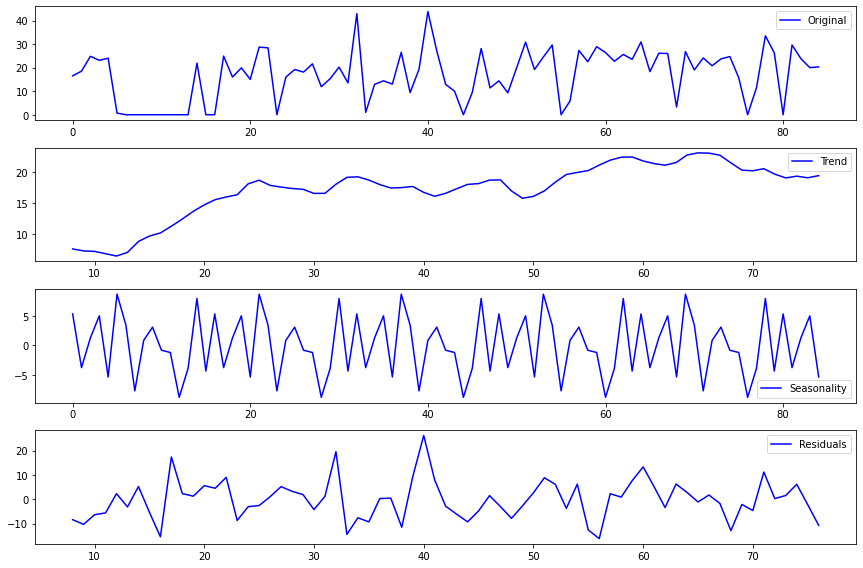

In [47]:
#Decomposition plot of the Arena District
decomposition_plot(qb_list[0])

In [48]:
qb_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2017-09-07 to 2022-01-02
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Aaron Rodgers       72 non-null     float64
 1   Baker Mayfield      63 non-null     float64
 2   Dak Prescott        70 non-null     float64
 3   Derek Carr          80 non-null     float64
 4   Deshaun Watson      71 non-null     float64
 5   Jalen Hurts         32 non-null     float64
 6   Jameis Winston      61 non-null     float64
 7   Joe Burrow          27 non-null     float64
 8   Josh Allen          61 non-null     float64
 9   Justin Fields       17 non-null     float64
 10  Justin Herbert      32 non-null     float64
 11  Kirk Cousins        80 non-null     float64
 12  Kyler Murray        49 non-null     float64
 13  Lamar Jackson       63 non-null     float64
 14  Mac Jones           17 non-null     float64
 15  Matt Ryan           80 non-null     flo

### Stationarity Check

In [49]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [50]:
# Get decomposition for stationarity check
decomposition = sm.tsa.seasonal_decompose(qb_list[0], model='additive', period=16)
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

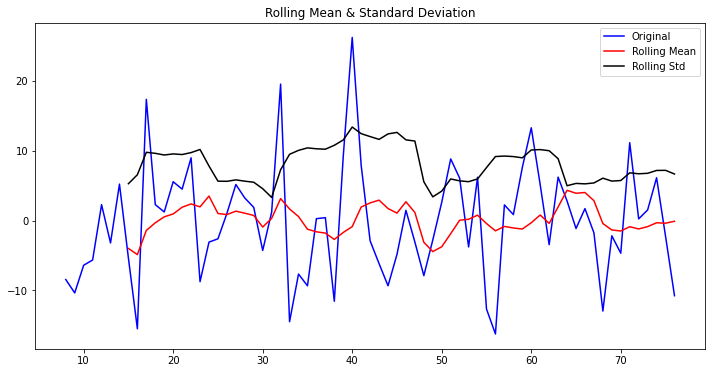

Results of Dickey-Fuller Test: 

Test Statistic                 -5.403261
p-value                         0.000003
#Lags Used                      5.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [51]:
stationarity_check(ts_log_decompose)

The p-value is <0.05, which means we accept the null hypothesis that the residuals are stationary. We can move on to check our autocorrelation and partial autocorrelation plots.

### Autocorrelation and Partial Autocorrelation

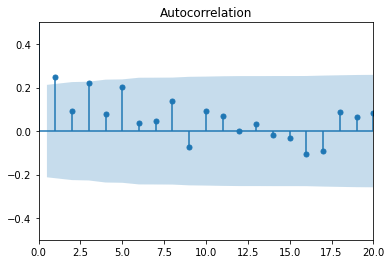

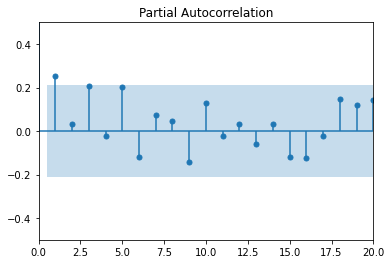

In [52]:
plot_acf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()
plot_pacf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()

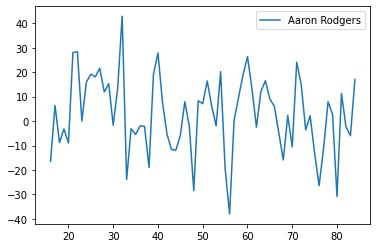

In [53]:
qb_list[0].diff(periods=16).plot();

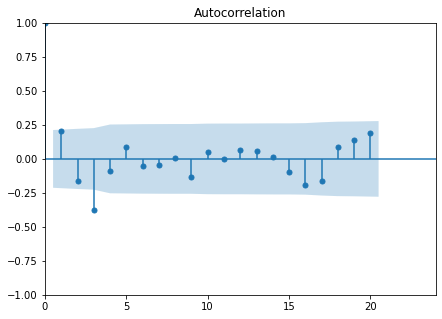

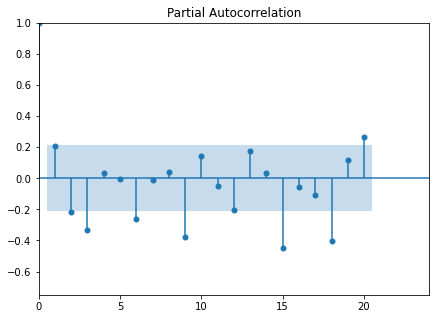

In [80]:
rcParams['figure.figsize']=7,5
plot_acf(qb_list[0].diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(qb_list[0].diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-0.75,1);plt.show()

### Gridsearch for SARIMAX Model

Next, I am going to conduct gridsearch to find optimal values for (p,d,q) and (P,D,Q,s) ranked by lowest AIC. This will provide optimal parameters for each of my players for Sarimax modeling. 

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 16) for x in list(itertools.product(p, d, q))]

In [ ]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for df, name in zip(qb_list, qb_list_names):
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                exog=
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([name, comb, combs, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}16 : AIC Calculated = {}'.format(comb, combs, output.aic))
            except:
                continue


In [ ]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])
ans_df

In [ ]:
#Return the best set of parameters based on AIC
best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
best_para

In [54]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

ans = []
for df, name in zip(qb_list, qb_list_names):
    for comb in pdq:
        for combs in pdqs:


model = pm.auto_arima(qb_list[0], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      exogeneous=qb_snap_ts['snaps_Aaron Rodgers'],
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
output = mod.fit()
                ans.append([name, comb, combs, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}16 : AIC Calculated = {}'.format(comb, combs, output.aic))
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=651.133, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=752.997, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=676.557, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=709.318, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=651.451, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=651.197, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=704.028, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=669.576, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=650.948, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=652.931, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=652.937, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=652.591, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=653.288, Time=0.05 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=648.018, 

### Best Parameters SARIMAX Model

Now that we have our optimal parameters for each zip code from our gridsearch, we will use the to build a sarimax model for each zip code.  Following are 3 functions we will use to build, evaluate and test each model, and forecast predictions for each of our top 10 zip codes.

In [69]:
exog = qb_snap_ts['snaps_Baker Mayfield']
exog

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
80     0.0
81    63.0
82     0.0
83    68.0
84    71.0
Name: snaps_Baker Mayfield, Length: 85, dtype: float64

In [73]:
qb_list[1] = qb_list[1].reset_index().drop('Date', axis=1).fillna(0)
qb_list[1]

,Baker Mayfield
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
80,0.0
81,16.0
82,0.0
83,14.0


In [29]:
# Define function to build SARIMAX model, print summary and output diagnostic plots
def sarimax(ts, exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    '''
    Input: 
    ts : Time series data.
    order : (p, d, q) values for ARIMA. Default = (1, 1, 1)
    seasonal_order : Seasonal (P, D, Q, s) values for SARIMA.
        Default = (1, 1, 1, 12).
        
    Output:
    Prints model output summary.
    Plots model diagnostics.
    
    Returns: Model output.
    '''
    
    # Sarimax model
    SARIMAX = sm.tsa.statespace.SARIMAX(ts,
                                        exog=exog,
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                                            
    # Fit the model and print results
    output = SARIMAX.fit()
    
    # Print output summary
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18));
    
    return output

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
snaps_Baker Mayfield     0.2422      0.008     28.671      0.000       0.226       0.259
ar.L1                   -0.0599      0.103     -0.583      0.560      -0.261       0.141
sigma2                  25.9889      3.092      8.405      0.000      19.929      32.049


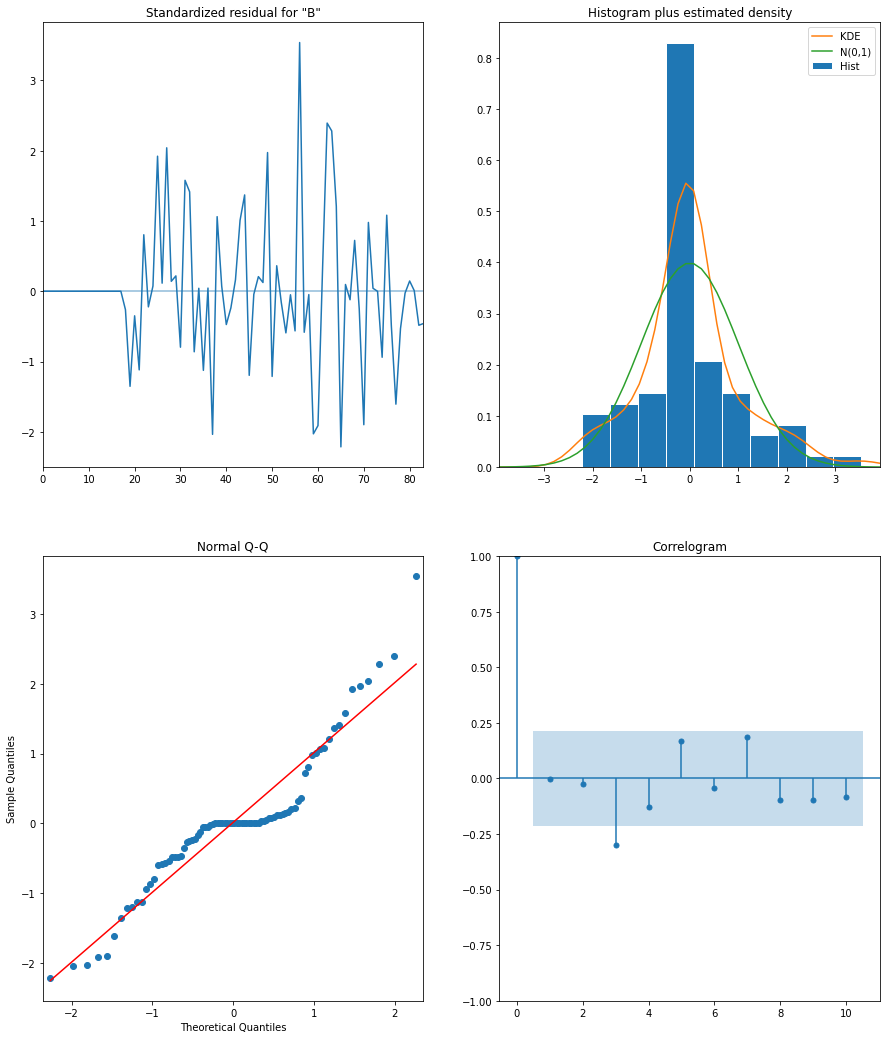

In [74]:
 AR_output = sarimax(qb_list[1], qb_snap_ts['snaps_Baker Mayfield'].fillna(0), order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))

In [42]:
def ose_forecast(ts, output, neighborhood =''):
    '''
    Plot forecast with real and predicted data.
    
    Input:
        ts : Time series.
        output : SARIMAX model output. 
        neighborhood : Name of city for plot title. 
        
    Output:
        Prints RMSE.
        Plots real vs. model predicted plot.
    '''

    # Get predictions starting from 2019-06-30 and calculate confidence intervals
    
    pred = output.get_prediction(start=pd.to_datetime('2019-06-30'), dynamic=False)
        
    # Get the real and predicted values
    ts_forecasted = pred.predicted_mean
    ts_truth = ts['2019-06-30':].value
    
    # Calc RMSE
    mse = mean_squared_error(ts_truth, ts_forecasted)
    rmse = np.sqrt(mse)

    # Print RMSE
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

    # Confidence Intervals
    pred_conf = pred.conf_int()

    ### Plot real vs predicted w/ confidence intervals ###

    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = ts['2017-06-30':].plot(label='observed')

    # Plot predicted values
    
    ts_forecasted.plot(ax=ax, label='one-step ahead forecast', alpha=0.5)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.3)
        
    # Title
    ax.set_title(neighborhood)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value (USD)')
    plt.legend()

    return plt.show()

In [58]:
# Forecast 5 year predictions - Home Sale Values #

def dynamic_forecast(ts, model_output, exog, steps, player='', save_fig=False):
    '''
    Plots dynamic forecast for specified time into the future.
    
    Inputs: 
        ts : Time series data.
        model_output : Output results from our model.
        years : n-years to forcast into the future.
        neighborhood: Name of neighborhood for plots
            
    Outputs:
        Prints : Time series plot with one step ahead forecast.
        Returns : Dictionary of predictions.
    
    '''
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, exog=exog, dynamic=True)
    future_conf = future.conf_int()
    
    ### Plot forecast ###
    
    # Observed
    ax = ts.plot(label='Observed', figsize=(12, 6))
    # Predicted
    future.predicted_mean.plot(ax=ax, label='dynamic forecast', alpha=0.9)

    # Confidence Intervals
    ax.fill_between(future_conf.index,
                    future_conf.iloc[:, 0],
                    future_conf.iloc[:, 1], color='k', alpha=.25)
    
    # Title
    ax.set_title(f"1 Year Forecast for {player}")
    
    # x & y-labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Sale Value (USD)')
    
    # Legend
    ax.legend()
    
    if save_fig:
        plt.savefig(f'./images/dynamic_forecast_{player}.jpeg')
    
    # Print plot
    plt.show()

    # Forecast prediction for n-years into the future
    forecast = future.predicted_mean
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    
    # Create dictionary of predictions
    predictions = {}
    predictions['forecast'] = forecast.round()
    predictions['minimum'] = minimum.round()
    predictions['maximum'] = maximum.round()
    
    return predictions

In [75]:
qb_snap_ts['snaps_Baker Mayfield'][-16:].replace(to_replace = 0, value=qb_snap_ts['snaps_Baker Mayfield'].mean())


69    61.000000
70    76.000000
71    78.000000
72    72.000000
73    55.000000
74    56.764706
75    59.000000
76    45.000000
77    36.000000
78    74.000000
79    60.000000
80    56.764706
81    63.000000
82    56.764706
83    68.000000
84    71.000000
Name: snaps_Baker Mayfield, dtype: float64

In [63]:
exog_forecast

69    62.000000
70    63.000000
71    72.000000
72    64.000000
73    59.000000
74    56.000000
75    73.000000
76    52.388235
77    74.000000
78    58.000000
79    82.000000
80    52.388235
81    63.000000
82    62.000000
83    59.000000
84    63.000000
Name: snaps_Aaron Rodgers, dtype: float64

In [76]:
exog_forecast = qb_snap_ts['snaps_Baker Mayfield'][-16:].replace(to_replace = 0, 
                                                                value=qb_snap_ts['snaps_Baker Mayfield'].mean())
                                                                     
future = AR_output.get_forecast(steps=16, exog=exog_forecast, dynamic=True)
future_conf = future.conf_int()

In [77]:
forecast = future.predicted_mean

In [78]:
forecast[:17]

85     14.903467
86     18.396628
87     18.889303
88     17.435816
89     13.319049
90     13.746397
91     14.287706
92     10.897403
93      8.717922
94     17.920173
95     14.529870
96     13.746397
97     15.256364
98     13.746397
99     16.467186
100    17.193680
Name: predicted_mean, dtype: float64

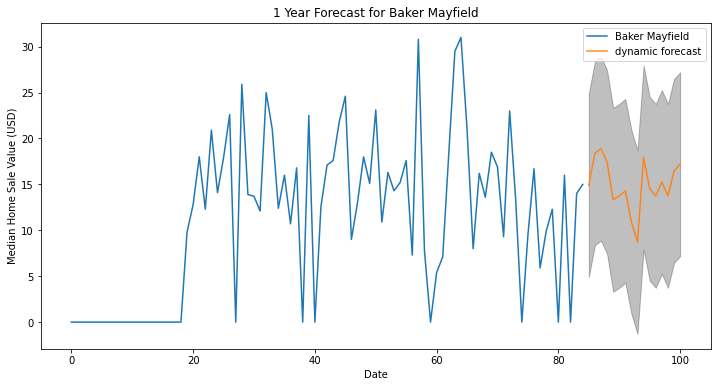

{'forecast': 85     15.0
 86     18.0
 87     19.0
 88     17.0
 89     13.0
 90     14.0
 91     14.0
 92     11.0
 93      9.0
 94     18.0
 95     15.0
 96     14.0
 97     15.0
 98     14.0
 99     16.0
 100    17.0
 Name: predicted_mean, dtype: float64,
 'minimum': 7.0,
 'maximum': 27.0}

In [79]:
dynamic_forecast(qb_list[1], AR_output, exog_forecast, 16, player='Baker Mayfield', save_fig=False)


## Facebook Prophet Modeling

In [194]:
qb_fb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_fb_list.append(player)

qb_fb_list[0]

Date
2017-09-07    16.5
2017-09-14    18.5
2017-09-21    24.8
2017-09-28    23.1
2017-10-05    24.0
2017-10-12     0.7
2017-10-19     NaN
2017-10-26     NaN
2017-11-02     NaN
2017-11-09     NaN
2017-11-16     NaN
2017-11-23     NaN
2017-11-30     NaN
2017-12-07     NaN
2017-12-14    21.9
2017-12-23     NaN
2017-12-31     NaN
2018-09-06    24.9
2018-09-13    16.0
2018-09-20    19.9
2018-09-27    15.0
2018-10-04    28.7
2018-10-11    28.4
2018-10-18     NaN
2018-10-25    15.9
2018-11-01    19.2
2018-11-08    18.1
2018-11-15    21.6
2018-11-22    11.9
2018-11-29    15.3
2018-12-06    20.2
2018-12-13    13.5
2018-12-22    42.9
2018-12-30     1.0
2019-09-05    12.9
2019-09-12    14.4
2019-09-19    13.0
2019-09-26    26.5
2019-10-03     9.4
2019-10-10    19.3
2019-10-17    43.8
2019-10-24    27.1
2019-10-31    12.9
2019-11-07    10.0
2019-11-14     NaN
2019-11-21     9.5
2019-11-28    28.1
2019-12-05    11.4
2019-12-12    14.4
2019-12-20     9.3
2019-12-27    20.0
2020-09-10    30.8
2020-09

In [195]:
# Set the uncertainty interval to 95% (the Prophet default is 80%)
Model = proph(interval_width=0.95)

In [196]:
# Rename the columns [Month, AirPassengers] to [ds, y]
qb_fb_list[0] = qb_fb_list[0].reset_index().rename(columns={'Date': 'ds',
                                                     'Aaron Rodgers (GB)': 'y'})
qb_fb_list[0]

,ds,y
0,2017-09-07,16.5
1,2017-09-14,18.5
2,2017-09-21,24.8
3,2017-09-28,23.1
4,2017-10-05,24.0
5,2017-10-12,0.7
6,2017-10-19,NaN
7,2017-10-26,NaN
8,2017-11-02,NaN
9,2017-11-09,NaN


In [197]:
bye = [6, 23, 44, 55, 76]
qb_fb_list[0] = qb_fb_list[0].drop(bye).fillna(0)
qb_fb_list[0]

,ds,y
17,2018-09-06,24.9
18,2018-09-13,16.0
19,2018-09-20,19.9
20,2018-09-27,15.0
21,2018-10-04,28.7
22,2018-10-11,28.4
24,2018-10-25,15.9
25,2018-11-01,19.2
26,2018-11-08,18.1
27,2018-11-15,21.6


In [198]:
# Fit the timeseries to Model
Model.fit(qb_fb_list[0])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [199]:
# Use make_future_dataframe() with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=16, freq='W')
future_dates.head()

,ds
0,2018-09-06
1,2018-09-13
2,2018-09-20
3,2018-09-27
4,2018-10-04


In [200]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-06,-7.862235,2.172470,30.107701,-7.862235,-7.862235,24.540196,24.540196,24.540196,-3.062094,-3.062094,-3.062094,27.602289,27.602289,27.602289,0.0,0.0,0.0,16.677961
1,2018-09-13,-7.852499,0.657286,31.280306,-7.852499,-7.852499,23.808259,23.808259,23.808259,-3.062094,-3.062094,-3.062094,26.870353,26.870353,26.870353,0.0,0.0,0.0,15.955761
2,2018-09-20,-7.842763,3.609367,33.296033,-7.842763,-7.842763,26.748040,26.748040,26.748040,-3.062094,-3.062094,-3.062094,29.810134,29.810134,29.810134,0.0,0.0,0.0,18.905278
3,2018-09-27,-7.833026,5.927686,34.170424,-7.833026,-7.833026,28.267398,28.267398,28.267398,-3.062094,-3.062094,-3.062094,31.329492,31.329492,31.329492,0.0,0.0,0.0,20.434372
4,2018-10-04,-7.823290,8.542968,35.648957,-7.823290,-7.823290,29.069314,29.069314,29.069314,-3.062094,-3.062094,-3.062094,32.131407,32.131407,32.131407,0.0,0.0,0.0,21.246024


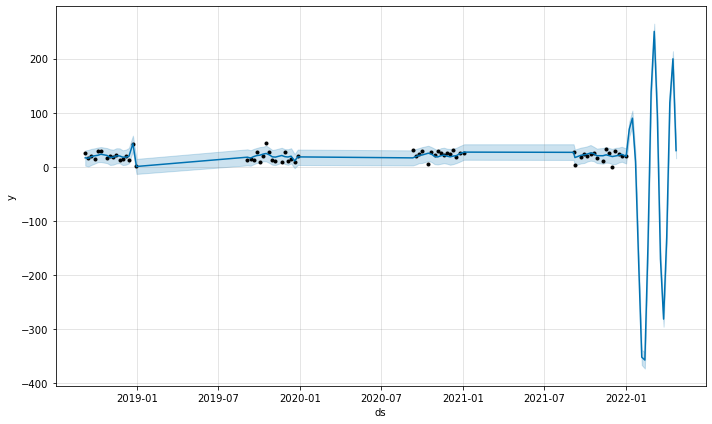

In [201]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

In [ ]:
m = proph()
m.fit(qb_fb_list[0])

#%% Forecast 1 year
weeks = 16
future = m.make_future_dataframe(periods=weeks)
future.tail()

fig1 = m.plot(forecast)
plt.close()
fig2 = m.plot_components(forecast)


## Interpret Results

### Projections for 3 and 5 year ROI

I am now going to make a dataframe that will contain our projected metrics based upon our sarimax model forecasting.

In [74]:
def projections(ts, zipcodes, years):
    '''
    Calculate projections for each zip code.
        - Current Value
        - ROI (return on investment)
        
    Input:
        ts : time series data.
        zipcodes : list of zip codes to iterate through.
        years : n-number of years to forecast.
        
    Output:
        Returns dataframe with:
        - zip code
        - investment value (current value)
        - predicted value and errors
        - predicted ROI and errors

    '''
    
    # Define steps for forecasting
    steps = years*12
    
    # Create list to append projection metrics
    projections = []
    
    # Iterate through time series of each zip code
    for zipcode in zipcodes:
        
        # Time series of zip code
        zip_ts = ts[ts['RegionName'] == zipcode]
        to_drop = ['RegionName']
        zip_ts = zip_ts.drop(to_drop, axis=1)
        
        # Plug the optimal parameter values into a new SARIMAX model
        # I used the values that were the most frequent for out top 10 zipcodes
        SARIMAX = sm.tsa.statespace.SARIMAX(zip_ts,
                                            order=(1, 1, 1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        # Fit the model and print results
        output = SARIMAX.fit()
    
        # Get forecast and confidence interval for steps ahead in future
        forecast = output.get_forecast(steps=steps, dynamic=True)
        conf_int = forecast.conf_int()

        # Show prediction for end of step-period
        pred_mean = forecast.predicted_mean[-1]
        pred_mean_min = conf_int.iloc[-1,0]
        pred_mean_max = conf_int.iloc[-1,1]
        
        # Last value of the time series - this will be used to calculate projected ROI
        current_value = zip_ts['value'][-1]
        
        # ROI (Return on Investment) as Percentage
        ROI = ((pred_mean-current_value)/current_value *100)
        ROI_min = ((pred_mean_min-current_value)/current_value *100)
        ROI_max = ((pred_mean_max-current_value)/current_value *100)
        
        # Create DataFrame
        
        # Initiate empty dictionary
        predicted = {}

        # Columns for df
        predicted['Zip Code'] = zipcode
        predicted['Investment Value ($)'] = current_value.round(2)
        predicted['Predicted Sale Price ($)'] = pred_mean.round(2)
        predicted['Min Pred Sale Price ($)'] = pred_mean_min.round(2)
        predicted['Max Pred Sale Price ($)'] = pred_mean_max.round(2)
        predicted['Predicted ROI (%)'] = ROI.round()
        predicted['Min Pred ROI (%)'] = ROI_min.round()
        predicted['Max Pred ROI (%)'] = ROI_max.round()
        
        # Append to list
        projections.append(predicted)
        
        # Return in DataFrame format     
    return pd.DataFrame.from_dict(projections)

In [75]:
# Get 3 year projections for top 10 zip codes
three_year_projections = projections(model_df, zip_list, years=3)
three_year_projections

,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
0,78203,241568.0,339839.66,283808.21,395871.11,41.0,17.0,64.0
1,78202,228219.0,316210.20,277737.86,354682.55,39.0,22.0,55.0
2,78207,148461.0,217501.24,180366.22,254636.25,47.0,21.0,72.0
3,78638,555727.0,930184.77,673410.44,1186959.09,67.0,21.0,114.0
4,78055,361314.0,569344.07,465645.71,673042.44,58.0,29.0,86.0
5,78210,234712.0,337287.14,295798.77,378775.51,44.0,26.0,61.0
6,78237,163415.0,237227.36,199425.67,275029.05,45.0,22.0,68.0
7,78623,509544.0,827218.41,638932.68,1015504.15,62.0,25.0,99.0
8,78133,473175.0,837285.82,594395.25,1080176.39,77.0,26.0,128.0
9,78220,183720.0,260936.10,226854.29,295017.91,42.0,23.0,61.0


In [77]:
# Get 5 year projections for top 10 zip codes
five_year_projections = projections(model_df, zip_list, years=5)
five_year_projections

,Zip Code,Investment Value ($),Predicted Sale Price ($),Min Pred Sale Price ($),Max Pred Sale Price ($),Predicted ROI (%),Min Pred ROI (%),Max Pred ROI (%)
0,78203,241568.0,405675.97,301026.60,510325.34,68.0,25.0,111.0
1,78202,228219.0,374877.90,303162.47,446593.33,64.0,33.0,96.0
2,78207,148461.0,264755.34,195127.43,334383.26,78.0,31.0,125.0
3,78638,555727.0,1187523.76,698988.57,1676058.95,114.0,26.0,202.0
4,78055,361314.0,708782.46,507903.17,909661.75,96.0,41.0,152.0
5,78210,234712.0,406120.38,327701.41,484539.36,73.0,40.0,106.0
6,78237,163415.0,287589.35,215798.43,359380.27,76.0,32.0,120.0
7,78623,509544.0,1048415.61,669826.72,1427004.49,106.0,31.0,180.0
8,78133,473175.0,1093740.35,582965.84,1604514.85,131.0,23.0,239.0
9,78220,183720.0,313951.99,249978.26,377925.71,71.0,36.0,106.0


### Barplots of ROI Projections and Errors

In [81]:
# Barplot for x years projection with 95% confidence intervals
def projection_barplot(df, years=3, save_fig=False):
    # Plot Predicted Mean Home Sale Values #

    # Get errors; (pred mean - lower bound of conf interval)
    errors = df['Predicted ROI (%)'] - df['Min Pred ROI (%)']
    df['errors'] = errors

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot barplot of ROI with errors
    plt.rcParams.update({'font.size': 18})
    df.plot(x='Neighborhood', 
            y='Predicted ROI (%)', 
            kind='bar',
            ax=ax, 
            color='none', 
            ecolor='black',
            capsize=10,
            yerr='errors', 
            legend=False)
    #Labels
    ax.set_xlabel('Neighborhood')
    ax.set_ylabel('Predicted ROI (%)')
    plt.title(f'{years} Year ROI w/ 95% Confidence Intervals')

    # Predicted ROI
    ax.scatter(x=pd.np.arange(df.shape[0]),
               marker='s', 
               s=40, 
               y=df['Predicted ROI (%)'], 
               color='black')
    
    # Line to help visualize on the y-axis
    ax.axhline(y=50, linestyle='--', color='red', linewidth=1.5)
    
    if save_fig:
        fig.savefig(f'./images/barplot_{years}.jpeg')
    
    # Rotate zip code labels 45 degrees
    plt.xticks(rotation = 45, size = 14)
    plt.show();

## Recommendations

## Future Work